In [1]:
# Import libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import root_mean_squared_error
import re
from apyori import apriori
import matplotlib.pyplot as plt
import seaborn as sns
from apyori import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
import random
random.seed(1234)
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
from tabulate import tabulate
import time

# Read and Check Data

In [2]:
# Read data
df_train = pd.read_csv("Groceries data train.csv")
df_test = pd.read_csv("Groceries data test.csv")

In [3]:
# Check for missing values in train set
df_train.isna().sum()

Member_number      0
Date               0
itemDescription    0
year               0
month              0
day                0
day_of_week        0
dtype: int64

In [4]:
# Check for missing values in test set
df_test.isna().sum()

Member_number      0
Date               0
itemDescription    0
year               0
month              0
day                0
day_of_week        0
dtype: int64

There is no missing data, so we do not have to apply any imputation technique.

# Data Visualisation

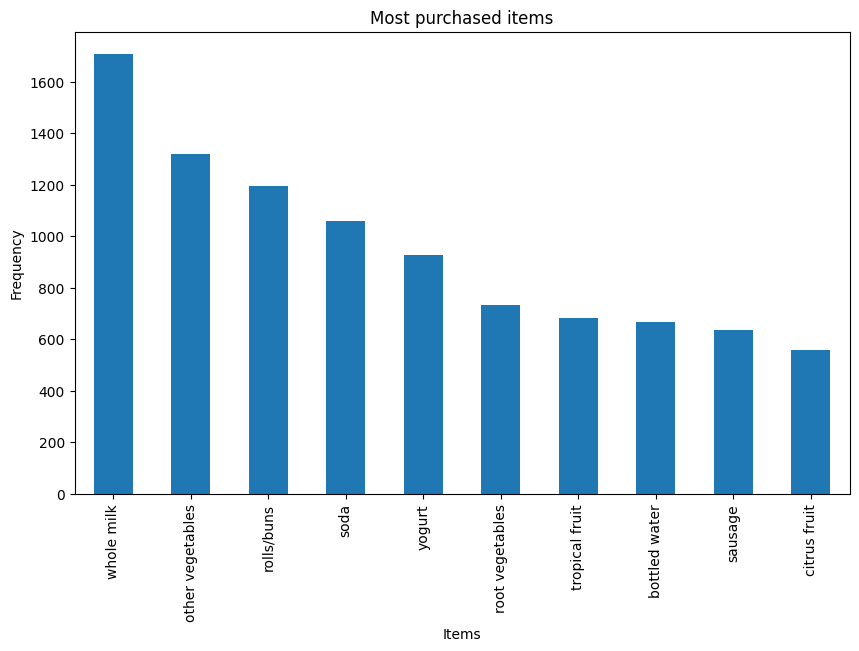

In [5]:
item_counts = df_train["itemDescription"].value_counts()
top_items = item_counts.head(10)

# Plot the most frequent items
plt.figure(figsize=(10, 6))
top_items.plot(kind="bar")
plt.title("Most purchased items")
plt.xlabel("Items")
plt.ylabel("Frequency")
plt.show()

The top products seem to be related to foods and drinks, which makes sense because people need to eat everyday.

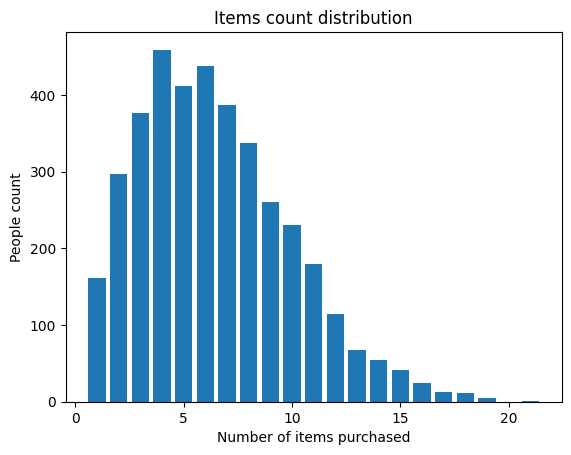

In [6]:
# Plot the user count distribution based on how many items they have bought
user_item_count = {}
for i, row in df_train.iterrows():
    user_id = row["Member_number"]
    item_name = row["itemDescription"]
    if user_id not in user_item_count:
        item_info = {}
        item_info[item_name] = 1
        user_item_count[user_id] = item_info
    else:
        if item_name not in user_item_count[user_id]:
            user_item_count[user_id][item_name] = 1
        else:
            user_item_count[user_id][item_name] += 1

for user_id in user_item_count:
    user_item_count[user_id] = len(user_item_count[user_id].keys())

item_count_dict = {}
for user_id in user_item_count:
    if user_item_count[user_id] not in item_count_dict:
        item_count_dict[user_item_count[user_id]] = 1
    else:
        item_count_dict[user_item_count[user_id]] += 1

item_count_dict = dict(sorted(item_count_dict.items(), key=lambda x: x[1]))

plt.bar(item_count_dict.keys(), item_count_dict.values())

plt.xlabel("Number of items purchased")
plt.ylabel("People count")
plt.title("Items count distribution")

plt.show()

The majority of people seem to have bought around 2-8 unique items within the span of the dataset. Every few buy more than 15 unique items.

<Axes: xlabel='itemDescription', ylabel='count'>

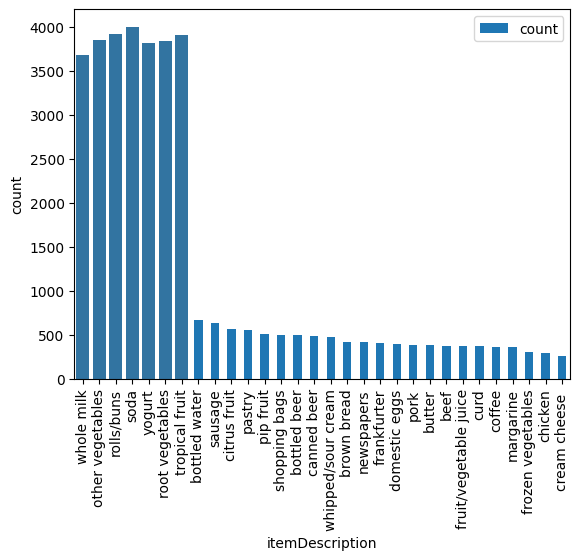

In [7]:
# Frequency of each item
df_train["itemDescription"].value_counts().head(30).plot(kind='bar')

# Frequency of transactions per day of the week
sns.countplot(x="day_of_week", data=df_train)

/var/folders/cq/m42sc9m95kg597cvjl06by_40000gn/T/ipykernel_9148/3079896692.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_train["Date"] = pd.to_datetime(df_train["Date"])
/var/folders/cq/m42sc9m95kg597cvjl06by_40000gn/T/ipykernel_9148/3079896692.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_train.set_index("Date")["itemDescription"].resample("M").count().plot()


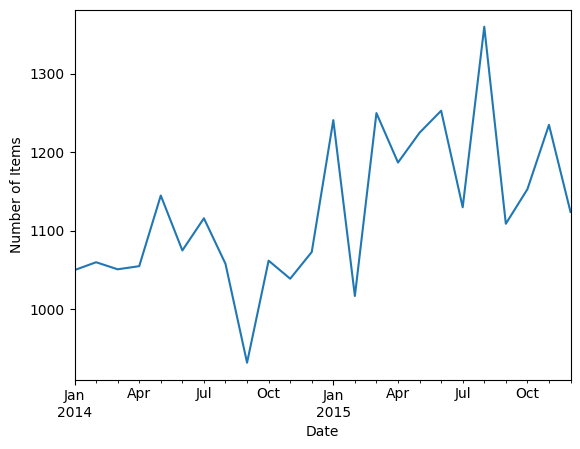

In [8]:
# analysis trend
df_train["Date"] = pd.to_datetime(df_train["Date"])
df_train.set_index("Date")["itemDescription"].resample("M").count().plot()
plt.ylabel("Number of Items")
plt.show()

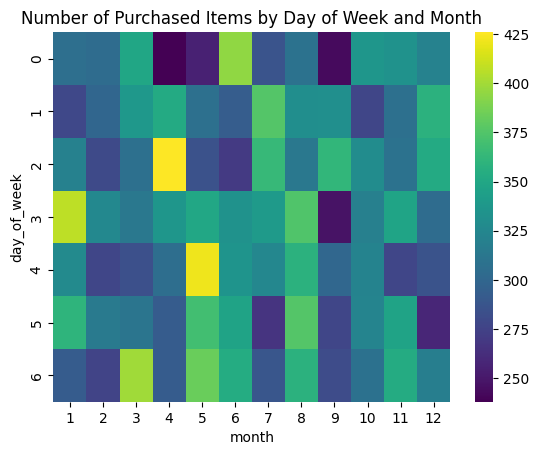

In [9]:
# Advanced visualizations
pivot_table = df_train.pivot_table(index='day_of_week', columns='month', values='itemDescription', aggfunc='count')
sns.heatmap(pivot_table, cmap='viridis')
plt.title('Number of Purchased Items by Day of Week and Month')
plt.show()

# System Code

This section is used to store the code for our system. The system is split into multiple classes as follows:
- Apriori: Handle Apriori algorithm.
- FPGrowth: Handle FPGrowth algorithm.
- CollaborativeFilteringItemBased: Handle collaborative filtering with item-to-item approach.
- CollaborativeFilteringUserBased: Handle collaborative filtering with user-to-user approach.
- HypridSystem: Handle combined method of pattern mining and collaborative filtering.
- Utils: Store general-purpose functions.
- Time: Calculate execution time of the models.

## Apriori Class

In [10]:
class Apriori:
    def __init__(self, df_train, df_test):
        # Convert dataframes into item-user tables
        self.train_data = Utils.preprocess(df_train)
        self.test_data = Utils.preprocess(df_test)
        
    def get_transactions(self):
        transactions = []

        for user_id in self.train_data.columns:
            transaction = []
            for item_name in self.train_data.index:
                if self.train_data.loc[item_name, user_id] > 0:
                    transaction.append(item_name)
            transactions.append(transaction)

        return transactions
    
    def get_rules(self, metrics="confidence"):
        print("Getting rules...\n")

        # Get the frequent item sets
        rules = apriori(self.get_transactions(), min_support=0.003, min_confidence=0.2, min_lift=3, min_length=2)
        rules = list(rules)

        # Get the final results
        lhs_list = []
        rhs_list = []
        support_list = []
        confidence_list = []
        lift_list = []

        for rule in rules:
            top_rule = rule[2][0]
            lhs_list.append(list(top_rule[0]))
            rhs_list.append(list(top_rule[1]))
            support_list.append(rule[1])
            confidence_list.append(top_rule[2])
            lift_list.append(top_rule[3])

        df_results = pd.DataFrame()
        df_results["lhs"] = lhs_list
        df_results["rhs"] = rhs_list
        df_results["support"] = support_list
        df_results["confidence"] = confidence_list
        df_results["lift"] = lift_list

        df_results = df_results.sort_values(metrics, ascending=False)

        return df_results
    
    def recommend_top_k_items_train(self, user_id, k=None, df_rules=pd.DataFrame()):
        items = []

        # Get the rules
        if df_rules.empty:
            df_rules = self.get_rules(metrics="confidence")
        
        # Get the items user bought in train set
        for item_name in self.train_data.index:
            if self.train_data.loc[item_name, user_id] > 0:
                items.append(item_name)

        recommendations = []

        # If any rhs is a subset of items, add the rhs to recommendations
        for i, row in df_rules.iterrows():
            if row["lhs"] <= items:
                recommendations += row["rhs"]

        # Remove duplicates while preserving the order
        recommendations = list(dict.fromkeys(recommendations))

        if len(recommendations) > k:
            recommendations = recommendations[:k]

        return recommendations
    
    def recommend_top_k_items_test(self, user_id, k=None, df_rules=pd.DataFrame()):
        items = []

        # Get the rules
        if df_rules.empty:
            df_rules = self.get_rules(metrics="confidence")
        
        # Get the items user bought in train set
        for item_name in self.train_data.index:
            if self.train_data.loc[item_name, user_id] > 0:
                items.append(item_name)

        recommendations = []

        # If any rhs is a subset of items, add the rhs to recommendations
        for i, row in df_rules.iterrows():
            if row["lhs"] <= items:
                recommendations += row["rhs"]

        # Remove duplicates while preserving the order
        recommendations = list(dict.fromkeys(recommendations))

        # Remove from recommendations items user has bought
        recommendations = [item for item in recommendations if item not in items]

        if len(recommendations) > k:
            recommendations = recommendations[:k]

        return recommendations
    
    def evaluate_train_set(self, k):
        truths = []
        predictions = []

        df_rules = self.get_rules(metrics="confidence")

        # Find users who bought at least k new items in the train set
        for user_id in tqdm(self.train_data.columns, desc="Evaluating"):
            # Find items user bought in train set
            train_items_column = self.train_data[user_id]
            train_items = []
            for item, count in train_items_column.items():
                if count > 0:
                    train_items.append(item)

            # Add ground truth and prediction
            if len(train_items) >= k:
                truths.append(train_items)
                predictions.append(self.recommend_top_k_items_train(user_id=user_id, k=k, df_rules=df_rules))

        # Return result
        if (len(truths) == 0):
            return 0
        else:
            return Utils.mapk(actual=truths, predicted=predictions, k=k)
    
    def evaluate_test_set(self, k):
        truths = []
        predictions = []

        df_rules = self.get_rules(metrics="confidence")

        # Find users who bought at least k new items in the test set
        for user_id in tqdm(self.test_data.columns, desc="Evaluating"):
            if user_id in self.train_data.columns:
                truth = []

                # Find items user bought in train set
                train_items_column = self.train_data[user_id]
                train_items = []
                for item, count in train_items_column.items():
                    if count > 0:
                        train_items.append(item)

                # If an item is in test set and not in train set, add to truth (this is a relevant item)
                test_items_column = self.test_data[user_id]
                for item, count in test_items_column.items():
                    if item not in train_items and count > 0:
                        truth.append(item)

                # Add ground truth and prediction for the user
                if len(truth) >= k:
                    truths.append(truth)
                    predictions.append(self.recommend_top_k_items_test(user_id=user_id, k=k, df_rules=df_rules))

        # Return result
        if (len(truths) == 0):
            return 0
        else:
            return Utils.mapk(actual=truths, predicted=predictions, k=k)

## FPGrowth Class

In [25]:
class FPGrowth:
    def __init__(self, df_train, df_test):
        self.train_data = self.preprocess(df_train)
        self.test_data = self.preprocess(df_test)

    def preprocess(self, df):
        # Preprocess item names
        df["itemDescription"] = df["itemDescription"].apply(Utils.preprocess_item_name)

        return df
    
    def get_rules(self):
        grouped = self.train_data.groupby(["Member_number"])["itemDescription"].apply(list).reset_index()
        transactions = grouped["itemDescription"].to_list()

        # transaction encoder initialisation
        encoder = TransactionEncoder()

        # convert to a format for frequent itemset mining
        encoded_array = encoder.fit_transform(transactions)

        # create dataframe
        df = pd.DataFrame(encoded_array, columns=encoder.columns_)

        # create frequent itemsets
        frequent_itemsets = fpgrowth(df, min_support=0.05, use_colnames=True) 
        frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

        # generate association rules
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
        rules = rules[rules['lift'] > 1]
    
        return rules
    
    def recommend_top_k_items_train(self, user_id, k=None, df_rules=pd.DataFrame()):
        # Get the rules
        if df_rules.empty:
            df_rules = self.get_rules()

        # Create utility matrices from train data
        train_table = pd.pivot_table(self.train_data, values="Date", index="itemDescription", columns="Member_number", aggfunc="count")
        # Fill missing values with 0
        train_table = train_table.fillna(0)

        # Get the items user bought in train set
        items = []
        for item_name in train_table.index:
            if train_table.loc[item_name, user_id] > 0:
                items.append(item_name)

        recommendations = []

        # If any lhs is a subset of items, add the rhs to recommendations
        for i, row in df_rules.iterrows():
            lhs = list(row["antecedents"])
            rhs = list(row["consequents"])
            if lhs <= items:
                recommendations += rhs

        # Remove duplicates while preserving the order
        recommendations = list(dict.fromkeys(recommendations))

        if len(recommendations) > k:
            recommendations = recommendations[:k]

        return recommendations

    def recommend_top_k_items_test(self, user_id, k=None, df_rules=pd.DataFrame()):
        # Get the rules
        if df_rules.empty:
            df_rules = self.get_rules()

        # Create utility matrices from train data
        train_table = pd.pivot_table(self.train_data, values="Date", index="itemDescription", columns="Member_number", aggfunc="count")
        # Fill missing values with 0
        train_table = train_table.fillna(0)

        # Get the items user bought in train set
        items = []
        for item_name in train_table.index:
            if train_table.loc[item_name, user_id] > 0:
                items.append(item_name)

        recommendations = []

        # If any lhs is a subset of items, add the rhs to recommendations
        for i, row in df_rules.iterrows():
            lhs = list(row["antecedents"])
            rhs = list(row["consequents"])
            if lhs <= items:
                recommendations += rhs

        # Remove duplicates while preserving the order
        recommendations = list(dict.fromkeys(recommendations))

        # Remove from recommendations items user has bought
        recommendations = [item for item in recommendations if item not in items]

        if len(recommendations) > k:
            recommendations = recommendations[:k]

        return recommendations
    
    def evaluate_train_set(self, k):
        train_table = pd.pivot_table(self.train_data, values="Date", index="itemDescription", columns="Member_number", aggfunc="count")
        train_table = train_table.fillna(0)

        test_table = pd.pivot_table(self.test_data, values="Date", index="itemDescription", columns="Member_number", aggfunc="count")
        test_table = test_table.fillna(0)

        truths = []
        predictions = []

        df_rules = self.get_rules()

        # Find users who bought at least k new items in the train set
        for user_id in tqdm(train_table.columns, desc="Evaluating"):
            # Find items user bought in train set
            train_items_column = train_table[user_id]
            train_items = []
            for item, count in train_items_column.items():
                if count > 0:
                    train_items.append(item)

             # Add ground truth and prediction for the user.
            if len(train_items) >= k:
                truths.append(train_items)
                predictions.append(self.recommend_top_k_items_train(user_id=user_id, k=k, df_rules=df_rules))

        # Return result
        if (len(truths) == 0):
            return 0
        else:
            return Utils.mapk(actual=truths, predicted=predictions, k=k)
    
    def evaluate_test_set(self, k):
        train_table = pd.pivot_table(self.train_data, values="Date", index="itemDescription", columns="Member_number", aggfunc="count")
        train_table = train_table.fillna(0)

        test_table = pd.pivot_table(self.test_data, values="Date", index="itemDescription", columns="Member_number", aggfunc="count")
        test_table = test_table.fillna(0)

        truths = []
        predictions = []

        df_rules = self.get_rules()

        # Find users who bought at least k new items in the test set
        for user_id in tqdm(test_table.columns, desc="Evaluating"):
            if user_id in train_table.columns:
                truth = []

                # Find items user bought in train set
                train_items_column = train_table[user_id]
                train_items = []
                for item, count in train_items_column.items():
                    if count > 0:
                        train_items.append(item)

                # If an item is in test set and not in train set, add to truth (this is a relevant item)
                test_items_column = test_table[user_id]
                for item, count in test_items_column.items():
                    if item not in train_items and count > 0:
                        truth.append(item)

                # Add ground truth and prediction for the user.
                if len(truth) >= k:
                    truths.append(truth)
                    predictions.append(self.recommend_top_k_items_test(user_id=user_id, k=k, df_rules=df_rules))

        # Return result
        if (len(truths) == 0):
            return 0
        else:
            return Utils.mapk(actual=truths, predicted=predictions, k=k)

## CollaborativeFilteringItemBased Class

In [12]:
class CollaborativeFilteringItemBased:
    def __init__(self, df_train, df_test):
        # Convert dataframes into item-user tables
        self.train_data = self.preprocess(df_train)
        self.test_data = self.preprocess(df_test)

    def preprocess(self, df):
        # Preprocess item names
        df["itemDescription"] = df["itemDescription"].apply(Utils.preprocess_item_name)

        # Convert dataframes into item-user tables
        data = pd.pivot_table(df, values="Date", index="itemDescription", columns="Member_number", aggfunc="count")

        # Fill missing values with 0
        data = data.fillna(0)

        return data
    
    def predict_item_count(self, user_id, item_name):
        # Get all the items that was bought by the target user (except item_name)
        sub_table = self.train_data.drop(item_name)
        items = sub_table[sub_table[user_id] > 0].values

        # Get the target item
        target_item = self.train_data.loc[item_name].values

        # Calculate similarity scores between target_item and each item in items
        similarities = [Utils.cosine_similarity(target_item, item) for item in items]
        similarities = np.array(similarities)

        # Get the counts of items
        item_counts = sub_table[user_id].to_list()
        item_counts = [count for count in item_counts if count > 0]
        item_counts = np.array(item_counts)

        # If all weights are 0, return 0 for count prediction
        if (np.sum(similarities) == 0):
            return 0
        
        # Calculate the weighted averaged of item_counts, using similarities as weights
        weighted_sum = np.dot(similarities, item_counts)
        weighted_sum /= np.sum(similarities)

        return weighted_sum
    
    def recommend_top_k_items_train(self, user_id, k):
        # Get all items in train set
        item_names = self.train_data.index.to_list()

        # Predict the count for each of the item
        count_predictions = []
        for i, _ in enumerate(item_names):
            count_predictions.append([item_names[i], self.predict_item_count(user_id=user_id, item_name=item_names[i])])

        # Sort the predictions
        count_predictions = sorted(count_predictions, key=lambda x: x[1], reverse=True)

        # Get the top k items
        top_items = []
        if k >= len(count_predictions):
            top_items = [x[0] for x in count_predictions]
        else:
            top_items = [x[0] for x in count_predictions][:k]

        return top_items
    
    def recommend_top_k_items_test(self, user_id, k):
        # Find the items that user has not bought
        item_names = self.train_data.loc[self.train_data[user_id] == 0].index.to_list()

        # Predict the count for each of the item
        count_predictions = []
        for i, _ in enumerate(item_names):
            count_predictions.append([item_names[i], self.predict_item_count(user_id=user_id, item_name=item_names[i])])

        # Sort the predictions
        count_predictions = sorted(count_predictions, key=lambda x: x[1], reverse=True)

        # Get the top k items
        top_items = []
        if k >= len(count_predictions):
            top_items = [x[0] for x in count_predictions]
        else:
            top_items = [x[0] for x in count_predictions][:k]

        return top_items
    
    def evaluate_train_set_rmse(self):
        # Get all users from train set
        user_ids = self.train_data.columns.to_list()

        # All each user, select the items they bought in the train set
        truths = []
        predictions = []
        for user_id in tqdm(user_ids, desc="Evaluating"):
            for item_name in self.train_data.index:
                if self.train_data.loc[item_name, user_id] > 0:
                    # Add the ground truth and prediction
                    truths.append(self.train_data.loc[item_name, user_id])
                    predictions.append(self.predict_item_count(user_id=user_id, item_name=item_name))

        # Return results
        return root_mean_squared_error(truths, predictions)
    
    def evaluate_test_set_rmse(self):
        # Get the ids of all users in test set that also exist in train set (we exclude new users from the calculation)
        user_ids = [user_id for user_id in self.test_data.columns if user_id in self.train_data.columns]

        # For each user, select the items they bought in the test set but not in the train set
        truths = []
        predictions = []
        for user_id in tqdm(user_ids, desc="Evaluating"):
            for item_name in self.test_data.index.to_list():
                if self.test_data.loc[item_name, user_id] > 0 and item_name in self.train_data.index.to_list() and self.train_data.loc[item_name, user_id] == 0:
                    # For each selected item, get the ground truth from test set and prediction from train set
                    truths.append(self.test_data.loc[item_name, user_id])
                    predictions.append(self.predict_item_count(user_id=user_id, item_name=item_name))

        # Return results
        return root_mean_squared_error(truths, predictions)

    def evaluate_train_set_mapk(self, k):
        truths = []
        predictions = []

        # Find users who bought at least k items in the train set
        for user_id in tqdm(self.train_data.columns, desc="Evaluating"):
            # Find items user bought in train set
            train_items_column = self.train_data[user_id]
            train_items = []
            for item, count in train_items_column.items():
                if count > 0:
                    train_items.append(item)

            if len(train_items) >= k:
                truths.append(train_items)
                predictions.append(self.recommend_top_k_items_train(user_id=user_id, k=k))

        # Return result
        if (len(truths) == 0):
            return 0
        else:
            return Utils.mapk(actual=truths, predicted=predictions, k=k)


    def evaluate_test_set_mapk(self, k):
        truths = []
        predictions = []

        # Find users who bought at least k new items in the test set
        for user_id in tqdm(self.test_data.columns, desc="Evaluating"):
            if user_id in self.train_data.columns:
                truth = []

                # Find items user bought in train set
                train_items_column = self.train_data[user_id]
                train_items = []
                for item, count in train_items_column.items():
                    if count > 0:
                        train_items.append(item)

                # If an item is in test set and not in train set, add to truth (this is a relevant item)
                test_items_column = self.test_data[user_id]
                for item, count in test_items_column.items():
                    if item not in train_items and count > 0:
                        truth.append(item)

                # Add ground truth and prediction for the user.
                if len(truth) >= k:
                    truths.append(truth)
                    predictions.append(self.recommend_top_k_items_test(user_id=user_id, k=k))

        # Print result
        if (len(truths) == 0):
            return 0
        else:
            return Utils.mapk(actual=truths, predicted=predictions, k=k)

## CollaborativeFilteringUserBased Class

In [13]:
class CollaborativeFilteringUserBased:
    def __init__(self, df_train, df_test):
        # Convert dataframes into item-user tables
        self.train_data = self.preprocess(df_train)
        self.test_data = self.preprocess(df_test)

    def preprocess(self, df):
        # Preprocess item names
        df["itemDescription"] = df["itemDescription"].apply(Utils.preprocess_item_name)

        # Convert dataframes into item-user tables
        data = pd.pivot_table(df, values="Date", index="Member_number", columns="itemDescription", aggfunc="count")

        # Fill missing values with 0
        data = data.fillna(0)

        return data
    
    def predict_item_count(self, user_id, item_name):
        # Get all the users that bought the item (except user_id)
        sub_table = self.train_data.drop(user_id)
        users = sub_table[sub_table[item_name] > 0].values

        # Get the target user vector
        target_user = self.train_data.loc[user_id].values

        # Calculate similarity scores between targer_user and each user in users
        similarities = [Utils.cosine_similarity(target_user, user) for user in users]
        similarities = np.array(similarities)

        # Get the counts of each user for the target item
        item_counts = sub_table[item_name].to_list()
        item_counts = [count for count in item_counts if count > 0]
        item_counts = np.array(item_counts)

        # If all weights are 0, return 0 for count prediction
        if (np.sum(similarities) == 0):
            return 0
        
        # Calculate the weighted averaged of item_counts, using similarities as weights
        weighted_sum = np.dot(similarities, item_counts)
        weighted_sum /= np.sum(similarities)

        return weighted_sum
    
    def recommend_top_k_items_train(self, user_id, k):
        # Find all items train set
        item_names = self.train_data.columns

        # Predict the count for each item
        count_predictions = []
        for i, _ in enumerate(item_names):
            count_predictions.append([item_names[i], self.predict_item_count(user_id=user_id, item_name=item_names[i])])

        # Sort the predictions
        count_predictions = sorted(count_predictions, key=lambda x: x[1], reverse=True)

        # Get the top k items
        top_items = []
        if k >= len(count_predictions):
            top_items = [x[0] for x in count_predictions]
        else:
            top_items = [x[0] for x in count_predictions][:k]

        return top_items
        
    def recommend_top_k_items_test(self, user_id, k):
        # Find the items that user has not bought
        item_names = []
        for item_name in self.train_data.columns:
            if self.train_data.loc[user_id, item_name] == 0:
                item_names.append(item_name)

        # Predict the count for each of the item
        count_predictions = []
        for i, _ in enumerate(item_names):
            count_predictions.append([item_names[i], self.predict_item_count(user_id=user_id, item_name=item_names[i])])

        # Sort the predictions
        count_predictions = sorted(count_predictions, key=lambda x: x[1], reverse=True)

        # Get the top k items
        top_items = []
        if k >= len(count_predictions):
            top_items = [x[0] for x in count_predictions]
        else:
            top_items = [x[0] for x in count_predictions][:k]

        return top_items
    
    def evaluate_train_set_rmse(self):
        # Get all users from train set
        user_ids = self.train_data.index.to_list()

        # For each user, select the items they bought in the train set
        truths = []
        predictions = []
        for user_id in tqdm(user_ids, desc="Evaluating"):
            for item_name in self.train_data.columns:
                if self.train_data.loc[user_id, item_name] > 0:
                    # Add the ground truth and prediction
                    truths.append(self.train_data.loc[user_id, item_name])
                    predictions.append(self.predict_item_count(user_id=user_id, item_name=item_name))

        # Return results
        return root_mean_squared_error(truths, predictions)
    
    def evaluate_test_set_rmse(self):
        # Get the ids of all users in test set that also exist in train set (we exclude new users from the calculation)
        user_ids = [user_id for user_id in self.test_data.index if user_id in self.train_data.index]

        # For each user, select the items they bought in the test set but not in the train set
        truths = []
        predictions = []
        for user_id in tqdm(user_ids, desc="Evaluating"):
            for item_name in self.test_data.columns:
                if self.test_data.loc[user_id, item_name] > 0 and item_name in self.train_data.columns and self.train_data.loc[user_id, item_name] == 0:
                    # For each selected item, get the ground truth from test set and prediction from train set
                    truths.append(self.test_data.loc[user_id, item_name])
                    predictions.append(self.predict_item_count(user_id=user_id, item_name=item_name))

        # Return results
        return root_mean_squared_error(truths, predictions)

    def evaluate_train_set_mapk(self, k):
        truths = []
        predictions = []

        # Find users who bought at least k items in the train set
        for user_id in tqdm(self.train_data.index, desc="Evaluating"):
            # Find items user bought in train set
            train_items_row = self.train_data.loc[user_id, :]
            train_items = []
            for item, count in train_items_row.items():
                if count > 0:
                    train_items.append(item)

            if len(train_items) >= k:
                truths.append(train_items)
                predictions.append(self.recommend_top_k_items_train(user_id=user_id, k=k))

        # Return result
        if (len(truths) == 0):
            return 0
        else:
            return Utils.mapk(actual=truths, predicted=predictions, k=k)

    def evaluate_test_set_mapk(self, k):
        truths = []
        predictions = []

        # Find users who bought at least k new items in the test set
        for user_id in tqdm(self.test_data.index, desc="Evaluating"):
            if user_id in self.train_data.index:
                truth = []

                # Find items user bought in train set
                train_items_row = self.train_data.loc[user_id, :]
                train_items = []
                for item, count in train_items_row.items():
                    if count > 0:
                        train_items.append(item)

                # If an item is in test set and not in train set, add to truth (this is a relevant item)
                test_items_row = self.test_data.loc[user_id, :]
                for item, count in test_items_row.items():
                    if item not in train_items and count > 0:
                        truth.append(item)

                # Add ground truth and prediction for the user.
                if len(truth) >= k:
                    truths.append(truth)
                    predictions.append(self.recommend_top_k_items_test(user_id=user_id, k=k))

        # Return result
        if (len(truths) == 0):
            return 0
        else:
            return Utils.mapk(actual=truths, predicted=predictions, k=k)

## HybridSystem Class

In [14]:
class HybridSystem:
    def __init__(self, df_train, df_test):
        self.train_data = df_train
        self.test_data = df_test

    def recommend_top_k_items_train(self, user_id, k, mining_method, rules):
        """
            mining_method: ["apriori", "fpgrowth]
        """

        cf = CollaborativeFilteringUserBased(df_train=self.train_data, df_test=self.test_data)
        cf_recs = cf.recommend_top_k_items_train(user_id=user_id, k=k)

        mining_recs = []
        if mining_method == "apriori":
            ap = Apriori(df_train=self.train_data, df_test=self.test_data)
            mining_recs = ap.recommend_top_k_items_train(user_id=user_id, k=k, df_rules=rules)
        elif mining_method == "fpgrowth":
            fpgrowth = FPGrowth(df_train=self.train_data, df_test=self.test_data)
            mining_recs = fpgrowth.recommend_top_k_items_train(user_id=user_id, k=k, df_rules=rules)

        # Get the weighted score for each item
        item_scores = {}

        for item in cf_recs:
            if item not in item_scores:
                item_scores[item] = 0.7
            else: 
                item_scores[item] += 0.7

        for item in mining_recs:
            if item not in item_scores:
                item_scores[item] = 0.3
            else:
                item_scores[item] += 0.3

        # Sort items based on their scores
        item_scores = {k: v for k, v in sorted(item_scores.items(), key=lambda item: item[1], reverse=True)}

        final_recs = list(item_scores.keys())

        if k < len(final_recs):
            final_recs = final_recs[:k]

        return final_recs

    def recommend_top_k_items_test(self, user_id, k, mining_method, rules):
        """
            mining_method: ["apriori", "fpgrowth]
        """

        cf = CollaborativeFilteringUserBased(df_train=self.train_data, df_test=self.test_data)
        cf_recs = cf.recommend_top_k_items_test(user_id=user_id, k=k)

        mining_recs = []
        if mining_method == "apriori":
            ap = Apriori(df_train=self.train_data, df_test=self.test_data)
            mining_recs = ap.recommend_top_k_items_test(user_id=user_id, k=k, df_rules=rules)
        elif mining_method == "fpgrowth":
            fpgrowth = FPGrowth(df_train=self.train_data, df_test=self.test_data)
            mining_recs = fpgrowth.recommend_top_k_items_test(user_id=user_id, k=k, df_rules=rules)

        # Get the weighted score for each item
        item_scores = {}

        for item in cf_recs:
            if item not in item_scores:
                item_scores[item] = 0.7
            else: 
                item_scores[item] += 0.7

        for item in mining_recs:
            if item not in item_scores:
                item_scores[item] = 0.3
            else:
                item_scores[item] += 0.3

        # Sort items based on their scores
        item_scores = {k: v for k, v in sorted(item_scores.items(), key=lambda item: item[1], reverse=True)}

        final_recs = list(item_scores.keys())

        if k < len(final_recs):
            final_recs = final_recs[:k]

        return final_recs
    
    def df_to_table(self, df):
        # Preprocess item names
        df["itemDescription"] = df["itemDescription"].apply(Utils.preprocess_item_name)

        # Convert dataframes into item-user tables
        data = pd.pivot_table(df, values="Date", index="itemDescription", columns="Member_number", aggfunc="count")

        # Fill missing values with 0
        data = data.fillna(0)

        return data
    
    def evaluate_train_set(self, k, mining_method):
        train_table = self.df_to_table(self.train_data)
        test_table = self.df_to_table(self.test_data)

        truths = []
        predictions = []

        rules = None
        if mining_method == "apriori":
            ap = Apriori(df_train=self.train_data, df_test=self.test_data)
            rules = ap.get_rules(metrics="confidence")
        else:
            fpgrowth = FPGrowth(df_train=self.train_data, df_test=self.test_data)
            rules = fpgrowth.get_rules()

        # Find users who bought at least k new items in the train set
        for user_id in tqdm(train_table.columns, desc="Evaluating"):
            # Find items user bought in train set
            train_items_column = train_table[user_id]
            train_items = []
            for item, count in train_items_column.items():
                if count > 0:
                    train_items.append(item)

             # Add ground truth and prediction for the user.
            if len(train_items) >= k:
                truths.append(train_items)
                predictions.append(self.recommend_top_k_items_train(user_id=user_id, k=k, mining_method=mining_method, rules=rules))

        # Return result
        if (len(truths) == 0):
            return 0
        else:
            return Utils.mapk(actual=truths, predicted=predictions, k=k)

    
    def evaluate_test_set(self, k, mining_method):
        train_table = self.df_to_table(self.train_data)
        test_table = self.df_to_table(self.test_data)

        truths = []
        predictions = []

        rules = None
        if mining_method == "apriori":
            ap = Apriori(df_train=self.train_data, df_test=self.test_data)
            rules = ap.get_rules(metrics="confidence")
        else:
            fpgrowth = FPGrowth(df_train=self.train_data, df_test=self.test_data)
            rules = fpgrowth.get_rules()

        # Find users who bought at least k new items in the test set
        for user_id in tqdm(test_table.columns, desc="Evaluating"):
            if user_id in train_table.columns:
                truth = []

                # Find items user bought in train set
                train_items_column = train_table[user_id]
                train_items = []
                for item, count in train_items_column.items():
                    if count > 0:
                        train_items.append(item)

                # If an item is in test set and not in train set, add to truth (this is a relevant item)
                test_items_column = test_table[user_id]
                for item, count in test_items_column.items():
                    if item not in train_items and count > 0:
                        truth.append(item)
 
                # Add ground truth and prediction for the user.
                if len(truth) >= k:
                    truths.append(truth)
                    predictions.append(self.recommend_top_k_items_test(user_id=user_id, k=k, mining_method=mining_method, rules=rules))

        # Print result
        if (len(truths) == 0):
            return 0
        else:
            return Utils.mapk(actual=truths, predicted=predictions, k=k)

## Utils Class

In [15]:
class Utils:
    @staticmethod
    def preprocess(df):
        # Preprocess item names
        df["itemDescription"] = df["itemDescription"].apply(Utils.preprocess_item_name)

        # Convert dataframes into item-user tables
        data = pd.pivot_table(df, values="Date", index="itemDescription", columns="Member_number", aggfunc="count")

        # Fill missing values with 0
        data = data.fillna(0)

        return data
    
    @staticmethod
    def preprocess_item_name(item_name):
        # Lowercase
        item_name = item_name.lower()

        # Remove extra white spaces
        item_name = re.sub(r"\s+", " ", item_name.strip())

        return item_name

    @staticmethod
    def cosine_similarity(v1, v2):
        # Calculate the dot product between v1 and v2
        dot_product = np.dot(v1, v2)

        # Calculate |v1| . |v2|
        magnitude = np.sqrt(np.sum(v1 ** 2) * np.sum(v2 ** 2))

        return dot_product / magnitude
    
    @staticmethod
    def apk(actual, predicted, k=10):
        """
        Computes the average precision at k.

        This function computes the average prescision at k between two lists of
        items.

        Parameters
        ----------
        actual : list
                A list of elements that are to be predicted (order doesn't matter)
        predicted : list
                    A list of predicted elements (order does matter)
        k : int, optional
            The maximum number of predicted elements

        Returns
        -------
        score : double
                The average precision at k over the input lists

        """
        if len(predicted)>k:
            predicted = predicted[:k]

        score = 0.0
        num_hits = 0.0

        for i,p in enumerate(predicted):
            if p in actual and p not in predicted[:i]:
                num_hits += 1.0
                score += num_hits / (i+1.0)

        if not actual:
            return 0.0

        return score / min(len(actual), k)
    
    @staticmethod
    def mapk(actual, predicted, k=10):
        """
        Computes the mean average precision at k.

        This function computes the mean average prescision at k between two lists
        of lists of items.

        Parameters
        ----------
        actual : list
                A list of lists of elements that are to be predicted 
                (order doesn't matter in the lists)
        predicted : list
                    A list of lists of predicted elements
                    (order matters in the lists)
        k : int, optional
            The maximum number of predicted elements

        Returns
        -------
        score : double
                The mean average precision at k over the input lists

        """
        return np.mean([Utils.apk(a,p,k) for a,p in zip(actual, predicted)])
    
    @staticmethod
    def generate_random_date(start_date=datetime(2014, 1, 1), end_date=datetime(2015, 12, 31)):
        # Convert start_date and end_date to datetime objects if needed
        if not isinstance(start_date, datetime):
            start_date = datetime.combine(start_date, datetime.min.time())
        if not isinstance(end_date, datetime):
            end_date = datetime.combine(end_date, datetime.max.time())

        # Calculate the range in days
        days_range = (end_date - start_date).days

        # Generate a random number of days to add to the start date
        random_days = random.randint(0, days_range)

        # Add the random number of days to the start date to get the random date
        random_date = start_date + timedelta(days=random_days)

        return random_date
    
    @staticmethod
    def generate_data(n_samples, items):
        df = pd.DataFrame(columns=["Member_number", "Date", "itemDescription", "year", "month", "day", "day_of_week"])

        for _ in tqdm(range(n_samples), desc="Generating data", unit="sample"):
            user_id =  random.randint(1000, 5000)
            date = Utils.generate_random_date()
            item = random.choice(items)
            new_row = {
                "Member_number": user_id,
                "Date": date.strftime("%d/%m/%Y"),
                "itemDescription": item,
                "year": date.year,
                "month": date.month,
                "day": date.day,
                "day_of_week": date.weekday()
            }
            df.loc[len(df)] = new_row
        
        return df

## Time class

In [26]:
class Time:
    def __init__(self, data):
        self.df_train, self.df_test = train_test_split(data, test_size=0.2, random_state=1234)
    
    def calculate_time(self, k):
        user_times = []

        for user_id in tqdm(sorted(self.df_train["Member_number"].unique())[:100], desc="Calculating time"):
            start_time = time.time()

            # hybrid = HybridSystem(df_train=self.df_train, df_test=self.df_test)
            # fp = FPGrowth(df_train=self.df_train, df_test=self.df_test)
            # rules = fp.get_rules()
            # recs = hybrid.recommend_top_k_items_test(user_id=user_id, k=k, mining_method="fpgrowth", rules=rules)

            hybrid = CollaborativeFilteringUserBased(df_train=self.df_train, df_test=self.df_test)
            recs = hybrid.recommend_top_k_items_test(user_id=user_id, k=k)

            end_time = time.time()

            user_times.append(end_time - start_time)
            
        average_time = sum(user_times) / len(user_times)

        return average_time

# Data Pattern Mining

In [32]:
# Show top rules for Apriori
ap = Apriori(df_train=df_train, df_test=df_test)

rules = ap.get_rules(metrics="confidence")
rules.head(10)

Getting rules...



,lhs,rhs,support,confidence,lift
39,"[newspapers, other vegetables, sausage]",[yogurt],0.003099,0.631579,3.068348
6,"[canned beer, frozen vegetables]",[root vegetables],0.006198,0.545455,3.219512
20,"[bottled water, soda, whipped/sour cream]",[sausage],0.003099,0.521739,3.519467
44,"[soda, pip fruit, pastry]",[sausage],0.003099,0.480000,3.237909
33,"[specialty chocolate, citrus fruit]","[whole milk, other vegetables]",0.003874,0.428571,3.814778
15,"[brown bread, other vegetables, bottled water]",[pastry],0.003357,0.406250,3.114851
3,"[shopping bags, dessert]",[brown bread],0.003099,0.400000,3.921013
1,"[frozen meals, tropical fruit]",[bottled beer],0.003357,0.393939,3.330422
7,"[tropical fruit, chicken]",[pip fruit],0.004132,0.390244,3.242542
16,"[root vegetables, bottled water, soda]",[canned beer],0.003099,0.387097,3.338171


In [33]:
# Display top rules for FP-Growth
fp = FPGrowth(df_train=df_train, df_test=df_test)

rules = fp.get_rules()
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(whole milk),(other vegetables),0.347366,0.284866,0.112345,0.323420,1.135342,0.013392,1.056984,0.182657
1,(other vegetables),(whole milk),0.284866,0.347366,0.112345,0.394379,1.135342,0.013392,1.077628,0.166694
2,(whole milk),(rolls/buns),0.347366,0.263171,0.106147,0.305576,1.161130,0.014730,1.061065,0.212630
3,(rolls/buns),(whole milk),0.263171,0.347366,0.106147,0.403337,1.161130,0.014730,1.093806,0.188334
4,(whole milk),(soda),0.347366,0.235021,0.090393,0.260223,1.107235,0.008754,1.034068,0.148397
5,(soda),(whole milk),0.235021,0.347366,0.090393,0.384615,1.107235,0.008754,1.060531,0.126604
6,(whole milk),(yogurt),0.347366,0.205837,0.087293,0.251301,1.220876,0.015793,1.060724,0.277209
7,(yogurt),(whole milk),0.205837,0.347366,0.087293,0.424090,1.220876,0.015793,1.133223,0.227807
8,(other vegetables),(rolls/buns),0.284866,0.263171,0.080837,0.283772,1.078276,0.005868,1.028762,0.101511
9,(rolls/buns),(other vegetables),0.263171,0.284866,0.080837,0.307164,1.078276,0.005868,1.032184,0.098522


# Model Comparison

## Apriori

In [16]:
ap = Apriori(df_train=df_train, df_test=df_test)

apriori_results = {}

# Calculate results
for k in [1, 3, 5, 10]:
    apriori_results[f"train-{k}"] = ap.evaluate_train_set(k=k)
    apriori_results[f"test-{k}"] = ap.evaluate_test_set(k=k)

# Print results
print(tabulate([
    [
        "Train",
        apriori_results["train-1"],
        apriori_results["train-3"],
        apriori_results["train-5"],
        apriori_results["train-10"]
    ],
    [
        "Test",
        apriori_results["test-1"],
        apriori_results["test-3"],
        apriori_results["test-5"],
        apriori_results["test-10"]
    ]
], headers=["MAP@1", "MAP@3", "MAP@5", "MAP@10"]))

Getting rules...



Evaluating: 100%|██████████| 3872/3872 [00:04<00:00, 951.80it/s]


Getting rules...



Evaluating: 100%|██████████| 3566/3566 [00:03<00:00, 950.95it/s]


Getting rules...



Evaluating: 100%|██████████| 3872/3872 [00:03<00:00, 1088.68it/s]


Getting rules...



Evaluating: 100%|██████████| 3566/3566 [00:01<00:00, 1927.75it/s]


Getting rules...



Evaluating: 100%|██████████| 3872/3872 [00:02<00:00, 1425.78it/s]


Getting rules...



Evaluating: 100%|██████████| 3566/3566 [00:00<00:00, 5667.99it/s]


Getting rules...



Evaluating: 100%|██████████| 3872/3872 [00:00<00:00, 4721.95it/s]


Getting rules...



Evaluating: 100%|██████████| 3566/3566 [00:00<00:00, 34658.37it/s]

           MAP@1     MAP@3      MAP@5     MAP@10
-----  ---------  --------  ---------  ---------
Train  0.141529   0.11902   0.115733   0.121961
Test   0.0708707  0.072232  0.0736719  0.0991667


## FP-Growth

In [17]:
fp = FPGrowth(df_train=df_train, df_test=df_test)

fpgrowth_results = {}

# Calculate results
for k in [1, 3, 5, 10]:
    fpgrowth_results[f"train-{k}"] = fp.evaluate_train_set(k=k)
    fpgrowth_results[f"test-{k}"] = fp.evaluate_test_set(k=k)

# Print results
print(tabulate([
    [
        "Train",
        fpgrowth_results["train-1"],
        fpgrowth_results["train-3"],
        fpgrowth_results["train-5"],
        fpgrowth_results["train-10"]
    ],
    [
        "Test",
        fpgrowth_results["test-1"],
        fpgrowth_results["test-3"],
        fpgrowth_results["test-5"],
        fpgrowth_results["test-10"]
    ]
], headers=["MAP@1", "MAP@3", "MAP@5", "MAP@10"]))

Evaluating: 100%|██████████| 3566/3566 [00:00<00:00, 14909.59it/s]

          MAP@1      MAP@3      MAP@5     MAP@10
-----  --------  ---------  ---------  ---------
Train  0.262913  0.144454   0.0981497  0.0555462
Test   0.125832  0.0718069  0.0550781  0.0666667


## User-to-user

In [21]:
cf_user = CollaborativeFilteringUserBased(df_train=df_train, df_test=df_test)

cf_user_results = {}

# Calculate results
cf_user_results[f"train-rmse"] = cf_user.evaluate_train_set_rmse()
cf_user_results[f"test-rmse"] = cf_user.evaluate_test_set_rmse()
for k in [1, 3, 5, 10]:
    cf_user_results[f"train-mapk-{k}"] = cf_user.evaluate_train_set_mapk(k=k)
    cf_user_results[f"test-mapk-{k}"] = cf_user.evaluate_test_set_mapk(k=k)

# Print results
print(tabulate([
    [
        "Train",
        cf_user_results["train-rmse"],
        cf_user_results["train-mapk-1"],
        cf_user_results["train-mapk-3"],
        cf_user_results["train-mapk-5"],
        cf_user_results["train-mapk-10"]
    ],
    [
        "Test",
        cf_user_results["test-rmse"],
        cf_user_results["test-mapk-1"],
        cf_user_results["test-mapk-3"],
        cf_user_results["test-mapk-5"],
        cf_user_results["test-mapk-10"]
    ]
], headers=["RMSE", "MAP@1", "MAP@3", "MAP@5", "MAP@10"]))

Evaluating: 100%|██████████| 3566/3566 [00:01<00:00, 2701.77it/s]

           RMSE     MAP@1     MAP@3     MAP@5    MAP@10
-----  --------  --------  --------  --------  --------
Train  0.291293  0.496384  0.393706  0.299213  0.307537
Test   0.183137  0.174718  0.146589  0.14459   0.174775


## Item-to-item

In [24]:
cf_item = CollaborativeFilteringItemBased(df_train=df_train, df_test=df_test)

cf_item_results = {}

# Calculate results
cf_item_results[f"train-rmse"] = cf_item.evaluate_train_set_rmse()
cf_item_results[f"test-rmse"] = cf_item.evaluate_test_set_rmse()
for k in [1, 3, 5, 10]:
    cf_item_results[f"train-mapk-{k}"] = cf_item.evaluate_train_set_mapk(k=k)
    cf_item_results[f"test-mapk-{k}"] = cf_item.evaluate_test_set_mapk(k=k)

# Print results
print(tabulate([
    [
        "Train",
        cf_item_results["train-rmse"],
        cf_item_results["train-mapk-1"],
        cf_item_results["train-mapk-3"],
        cf_item_results["train-mapk-5"],
        cf_item_results["train-mapk-10"]
    ],
    [
        "Test",
        cf_item_results["test-rmse"],
        cf_item_results["test-mapk-1"],
        cf_item_results["test-mapk-3"],
        cf_item_results["test-mapk-5"],
        cf_item_results["test-mapk-10"]
    ]
], headers=["RMSE", "MAP@1", "MAP@3", "MAP@5", "MAP@10"]))

Evaluating: 100%|██████████| 3566/3566 [00:00<00:00, 4175.88it/s]

           RMSE      MAP@1      MAP@3      MAP@5      MAP@10
-----  --------  ---------  ---------  ---------  ----------
Train  0.348426  0.0219525  0.0171028  0.0170701  0.00851337
Test   0.250569  0.0130171  0.0103002  0.0105143  0.0152778


## User-to-user + Apriori

In [27]:
hybrid = HybridSystem(df_train=df_train, df_test=df_test)

user_ap_results = {}

# Calculate results
for k in [1, 3, 5, 10]:
    user_ap_results[f"train-{k}"] = hybrid.evaluate_train_set(k=k, mining_method="apriori")
    user_ap_results[f"test-{k}"] = hybrid.evaluate_test_set(k=k, mining_method="apriori")

# Print results
print(tabulate([
    [
        "Train",
        user_ap_results["train-1"],
        user_ap_results["train-3"],
        user_ap_results["train-5"],
        user_ap_results["train-10"]
    ],
    [
        "Test",
        user_ap_results["test-1"],
        user_ap_results["test-3"],
        user_ap_results["test-5"],
        user_ap_results["test-10"]
    ]
], headers=["MAP@1", "MAP@3", "MAP@5", "MAP@10"]))

Getting rules...



Evaluating: 100%|██████████| 3872/3872 [18:44<00:00,  3.44it/s]


Getting rules...



Evaluating: 100%|██████████| 3566/3566 [15:44<00:00,  3.78it/s]


Getting rules...



Evaluating: 100%|██████████| 3872/3872 [15:58<00:00,  4.04it/s]


Getting rules...



Evaluating: 100%|██████████| 3566/3566 [07:22<00:00,  8.06it/s]


Getting rules...



Evaluating: 100%|██████████| 3872/3872 [12:09<00:00,  5.31it/s]


Getting rules...



Evaluating: 100%|██████████| 3566/3566 [02:14<00:00, 26.55it/s]


Getting rules...



Evaluating: 100%|██████████| 3872/3872 [03:25<00:00, 18.80it/s]


Getting rules...



Evaluating: 100%|██████████| 3566/3566 [00:01<00:00, 2153.43it/s]

          MAP@1     MAP@3     MAP@5    MAP@10
-----  --------  --------  --------  --------
Train  0.496384  0.389166  0.284033  0.298933
Test   0.174718  0.145609  0.134648  0.174775


## User-to-user + FP-Growth

In [28]:
user_fp_results = {}

# Calculate results
for k in [1, 3, 5, 10]:
    user_fp_results[f"train-{k}"] = hybrid.evaluate_train_set(k=k, mining_method="fpgrowth")
    user_fp_results[f"test-{k}"] = hybrid.evaluate_test_set(k=k, mining_method="fpgrowth")

# Print results
print(tabulate([
    [
        "Train",
        user_fp_results["train-1"],
        user_fp_results["train-3"],
        user_fp_results["train-5"],
        user_fp_results["train-10"]
    ],
    [
        "Test",
        user_fp_results["test-1"],
        user_fp_results["test-3"],
        user_fp_results["test-5"],
        user_fp_results["test-10"]
    ]
], headers=["MAP@1", "MAP@3", "MAP@5", "MAP@10"]))

Evaluating: 100%|██████████| 3566/3566 [00:01<00:00, 1998.19it/s]

          MAP@1     MAP@3     MAP@5    MAP@10
-----  --------  --------  --------  --------
Train  0.496384  0.374699  0.281827  0.299991
Test   0.174718  0.147603  0.146243  0.174775


# Estimate Time for user-to-user

In [29]:
time_results = {}

# Calculate the time
for n in [10000, 100000, 1000000]:
    df = None
    if n == 1000000:
        df = pd.read_csv("data/data_1000000.csv")
    else:
        df = df = Utils.generate_data(n_samples=n, items=df_train["itemDescription"].apply(Utils.preprocess_item_name).to_list())

    time_module = Time(data=df)

    for k in [1, 3, 5, 10]:
        average_time = time_module.calculate_time(k=k)
        time_results[f"{n}-{k}"] = average_time

# Print results
print(tabulate([
    [
        "MAP@1",
        time_results["10000-1"],
        time_results["100000-1"],
        time_results["1000000-1"]
    ],
    [
        "MAP@3",
        time_results["10000-3"],
        time_results["100000-3"],
        time_results["1000000-3"]
    ],
    [
        "MAP@5",
        time_results["10000-5"], 
        time_results["100000-5"],
        time_results["1000000-5"]
    ],
    [
        "MAP@10",
        time_results["10000-10"],
        time_results["100000-10"],
        time_results["1000000-10"]
    ],
], headers=["n = 10,000", "n = 100,000", "n = 1,000,000"]))

Calculating time: 100%|██████████| 100/100 [01:43<00:00,  1.04s/it]

          n = 10,000    n = 100,000    n = 1,000,000
------  ------------  -------------  ---------------
MAP@1       0.151004       0.388109          1.04318
MAP@3       0.150861       0.40632           1.02554
MAP@5       0.150659       0.404504          1.04649
MAP@10      0.149121       0.414066          1.03844
